In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, datetime, DataFrame, concat
from matplotlib import pyplot
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

/var/folders/pt/xwz928fd2l973b6cv37cynzc0000gn/T/ipykernel_17372/2005260626.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime, DataFrame, concat


In [72]:
df_cases = pd.read_csv("Cases.csv", encoding= 'unicode_escape')
df_deaths = pd.read_csv("Deaths.csv", encoding= 'unicode_escape')

In [76]:
# clean cases data and convert them to numeric
df_cases = df_cases.applymap(lambda x: x.strip())
df_cases = df_cases.applymap(lambda x: x.replace(",", ""))
df_cases = df_cases.applymap(lambda x: x.replace("..", ""))

cols = df_cases.columns[1:]
for col in cols:
    df_cases[col] = pd.to_numeric(df_cases[col],errors='coerce')

df_cases = df_cases.fillna(0)

In [77]:
df_deaths = df_deaths.fillna(0)

In [78]:
df_cases.describe()

,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,Kildare,Kilkenny,...,Meath,Monaghan,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.00000,89.000000,89.000000,89.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,70.797753,112.382022,112.876404,528.629213,275.516854,1859.606742,262.11236,141.910112,253.449438,83.853933,...,234.898876,107.033708,88.056180,65.820225,59.303371,141.876404,139.438202,99.213483,146.011236,116.584270
std,98.385857,133.600958,169.870059,787.547681,289.804837,1989.830067,323.01852,213.093484,239.444101,122.941463,...,268.083139,160.066424,88.958923,75.796162,83.251045,176.892033,214.388822,111.268050,229.175027,136.754908
min,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.00000,0.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,25.000000,20.000000,83.000000,47.000000,647.000000,32.00000,11.000000,83.000000,15.000000,...,44.000000,16.000000,24.000000,19.000000,0.000000,33.000000,18.000000,30.000000,18.000000,39.000000
50%,29.000000,55.000000,46.000000,217.000000,186.000000,1313.000000,112.00000,33.000000,206.000000,31.000000,...,135.000000,33.000000,65.000000,37.000000,22.000000,74.000000,50.000000,72.000000,58.000000,65.000000
75%,110.000000,158.000000,147.000000,756.000000,401.000000,2587.000000,408.00000,216.000000,343.000000,104.000000,...,349.000000,146.000000,127.000000,79.000000,94.000000,195.000000,152.000000,114.000000,187.000000,157.000000
max,427.000000,634.000000,955.000000,4244.000000,1260.000000,11865.000000,1299.00000,917.000000,1282.000000,679.000000,...,1291.000000,830.000000,401.000000,323.000000,472.000000,766.000000,1092.000000,655.000000,1227.000000,628.000000


In [79]:
df_deaths.describe()

,Carlow,Cavan,Clare,Cork,Donegal,Dublin,Galway,Kerry,Kildare,Kilkenny,...,Meath,Monaghan,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.134831,0.674157,0.932584,4.752809,1.505618,19.876404,1.000000,0.370787,2.584270,0.370787,...,1.146067,0.561798,0.303371,0.157303,0.089888,0.606742,1.056180,0.292135,1.123596,1.044944
std,0.906931,2.250128,2.679034,13.049975,3.418278,31.787226,4.100998,1.583882,6.602012,1.562210,...,3.301345,2.022347,1.472509,1.043365,0.748338,2.203396,3.706136,1.207949,3.948015,3.118530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,11.000000,14.000000,73.000000,17.000000,128.000000,24.000000,10.000000,33.000000,9.000000,...,14.000000,10.000000,10.000000,7.000000,7.000000,12.000000,22.000000,6.000000,22.000000,19.000000


In [ ]:
# showing covid cases cases 
# for col in df_cases.columns[1:]:
col = 'Dublin'
figure = plt.gcf()
figure.set_size_inches(30, 20)
plt.xticks(rotation=90)
plt.bar(df_cases['Date'], df_cases[col], width=0.35)
plt.show()

In [ ]:
# showing covid deaths cases 
# for col in df_deaths.columns[1:]:
# col = 'Dublin'
# figure = plt.gcf()
# figure.set_size_inches(30, 20)
# plt.xticks(rotation=90)
# plt.bar(df_deaths['Date'], df_deaths[col], width=0.35)
# plt.show()

<AxesSubplot:xlabel='Date'>

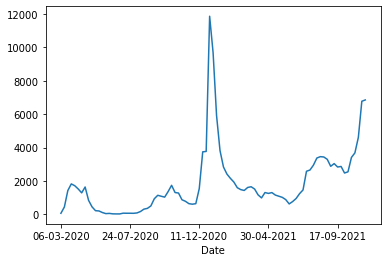

In [42]:
df_cases['Dublin'].plot()

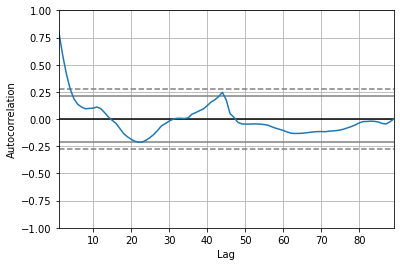

In [43]:
autocorrelation_plot(df_cases['Dublin'])
plt.show()

In [44]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [49]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

>expected=3303.0, predicted=3534.4
>expected=2884.0, predicted=3343.1
>expected=3045.0, predicted=2769.7
>expected=2841.0, predicted=3015.0
>expected=2874.0, predicted=2779.2
>expected=2482.0, predicted=2916.3
>expected=2553.0, predicted=2403.4
>expected=3415.0, predicted=2630.9
>expected=3687.0, predicted=3231.5
>expected=4619.0, predicted=4385.4
>expected=6776.0, predicted=5358.1
>expected=6856.0, predicted=5945.2
MAE: 468.367


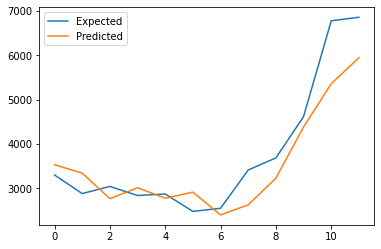

In [84]:
data = series_to_supervised(df_cases[['Dublin']].values, n_in=6)

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()